In [1]:
import gym, random, tqdm
from collections import defaultdict
import numpy as np, torch as th
from torchsummary import summary
import matplotlib.pyplot as mp
%matplotlib inline
from IPython.display import clear_output

In [2]:
from rl.environments.battleship import Battleship, stochastic_policy

In [3]:
env = Battleship()

In [4]:
class MLP(th.nn.Module):
    def __init__(self,):
        super().__init__()
        self.outputfn = th.nn.Sigmoid()
        self.layers = th.nn.Sequential(
        th.nn.Linear(100, 100), th.nn.ReLU(),
        th.nn.Linear(100, 100), th.nn.ReLU(),
        th.nn.Linear(100, 100), th.nn.ReLU())
        
        self.fc = th.nn.Linear(100, 100)
        self.ru = th.nn.LSTMCell(100,100)

    def init_recurrence(self, bsize=1):
        ht0 = th.zeros(bsize,100).float()
        ct0 = th.zeros(bsize,100).float()
        return (ht0,ct0)
    
    def __call__(self, x, recurrence=None):
        if recurrence is None: recurrence = self.init_recurrence(bsize=x.size(0))
            
        _= self.layers(x.view(x.size(0),-1))
        _= self.fc(_)

        recurrence = self.ru(_,recurrence)

        return self.outputfn(recurrence[0]), recurrence

In [5]:
net = MLP()
x = th.randn(1,1,10,10)
h,c = net.init_recurrence()
output,recurrence = net(x)
summary(net, x.size())
print(output.size())

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 100]          10,100
              ReLU-2                  [-1, 100]               0
            Linear-3                  [-1, 100]          10,100
              ReLU-4                  [-1, 100]               0
            Linear-5                  [-1, 100]          10,100
              ReLU-6                  [-1, 100]               0
            Linear-7                  [-1, 100]          10,100
          LSTMCell-8     [[-1, 100], [-1, 100]]               0
           Sigmoid-9                  [-1, 100]               0
Total params: 40,400
Trainable params: 40,400
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 0.15
Estimated Total Size (MB): 0.22
---------------------------------------------

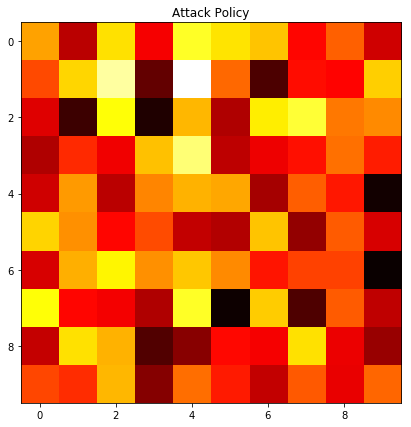

In [6]:
mp.figure(figsize=(17,7))
mp.title('Attack Policy')
mp.imshow(output.view(-1,10,10).squeeze().detach().numpy().swapaxes(1,-1).swapaxes(-1,-2), cmap='hot')

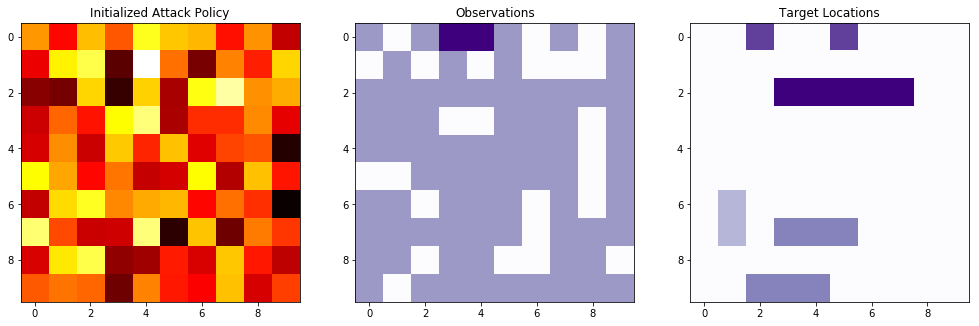

In [7]:
for _ in range(32): env.step(stochastic_policy())
input = th.from_numpy(env.enemies).view(1,1,10,10).float()
output,_ = net(input)
fig,(ax1,ax2,ax3) = mp.subplots(1,3, figsize=(17,7))
ax1.set_title('Initialized Attack Policy')
ax2.set_title('Observations')
ax3.set_title('Target Locations')
ax1.imshow(output.view(-1,10,10).squeeze().detach().numpy().swapaxes(1,-1).swapaxes(-1,-2), cmap='hot')
ax2.imshow(env.encode_observation(env.friends_attack_history, env.negatives), cmap='Purples')
ax3.imshow(env.enemies, cmap='Purples')

In [8]:
from rl.memory.experience_replay import ExperienceReplay
memory = ExperienceReplay()
from rl.policy.epsilon_greed import EpsilonGreed
policy = EpsilonGreed(epsilon_min=0.05, epsilon_decay=2**12, explicit_decay=True)
from rl.agents.dqn import DQN

optim = th.optim.Adam(net.parameters(), lr=5e-4, amsgrad=True)
lossfn = th.nn.SmoothL1Loss()

bsize = 256
updates = 32

agent = DQN(model=net, optim=optim, lossfn=lossfn, memory=memory, policy=policy)

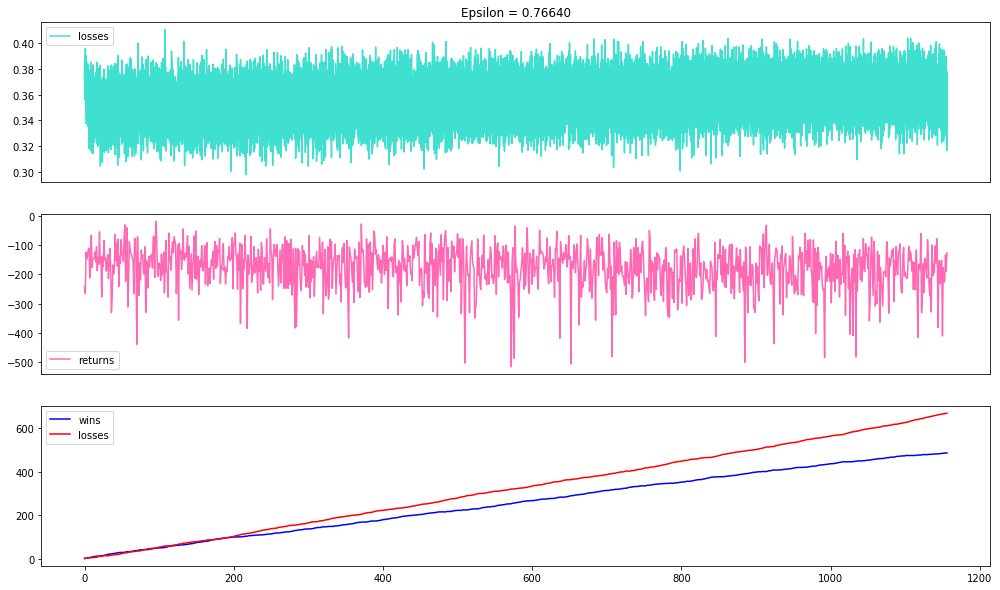

In [ ]:
episodes =  2**14
loss,returns = [],[]
wins,losses,w,l = [],[],0,0
for episode in range(episodes):
    state,rewards,terminal = env.reset(), [], False
    recurrence = agent.model.init_recurrence()
    while not terminal:
        probs,recurrence = agent.model(th.from_numpy(state).view(1,1,10,10).float(), recurrence)
        action= int(agent.policy(probs.squeeze()))
        
        sprime,reward,terminal,metadata = env.step(action)
        
        agent.memory.retain(np.expand_dims(state,axis=0),
                            action,
                            reward,
                            np.expand_dims(sprime,axis=0),
                            terminal)
        rewards.append(reward)
        state = sprime
            
    if metadata['status'] == 'success': w,l = w+1,l
    if metadata['status'] == 'failure': w,l = w,l+1
    wins.append(w)
    losses.append(l)
    agent.policy.decay_epsilon(episode)
    
    if len(agent.memory) > bsize:
        for _ in range(updates):
            loss.append(agent.update(bsize=bsize, verbose=False))
    returns.append(sum(rewards))   
    
    if episode > 1 and episode % 1 == 0:
        clear_output(True)
        fig,(ax1,ax2,ax3) = mp.subplots(3,1, figsize=(17,10))
        ax1.set_title('Epsilon = {:.5f}'.format(agent.policy.epsilon))
        ax1.plot(loss, label='losses', color='turquoise')
        ax2.plot(returns, label='returns', color='hotpink')
        ax3.plot(wins, label='wins', color='blue')
        ax3.plot(losses, label='losses', color='red')
        ax1.set_xticks([]),ax2.set_xticks([])
        ax1.legend()
        ax2.legend()
        ax3.legend()
        mp.show()